The following tutorial is available on the [Wallaroo Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/20231004-wallaroo-inference-server/wallaroo-model-cookbooks/computer-vision-yolov8).

## Computer Vision Yolov8n Deployment in Wallaroo

The [Yolov8](https://github.com/ultralytics/ultralytics) computer vision model is used for fast recognition of objects in images.  This tutorial demonstrates how to deploy a Yolov8n pre-trained model into a Wallaroo Ops server and perform inferences on it.

Wallaroo Ops Center provides the ability to publish Wallaroo pipelines to an Open Continer Initative (OCI) compliant registry, then deploy those pipelines on edge devices as Docker container or Kubernetes pods.  See [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/20230300/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/) for full details.

For this tutorial, the helper module `CVDemoUtils` and `WallarooUtils` are used to transform a sample image into a pandas DataFrame.  This DataFrame is then submitted to the Yolov8n model deployed in Wallaroo.

This demonstration follows these steps:

* Upload the Yolo8 model to Wallaroo
* Add the Yolo8 model as a Wallaroo pipeline step
* Deploy the Wallaroo pipeline and allocate cluster resources to the pipeline
* Perform sample inferences
* Undeploy and return the resources to the cluster.
* Publish the pipeline to the OCI registry configured in the Wallaroo Ops server.
* Deploy the pipeline as a Wallaroo Server on an edge device through Docker.

## References

* [Wallaroo Workspaces](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/):  Workspaces are environments were users upload models, create pipelines and other artifacts.  The workspace should be considered the fundamental area where work is done.  Workspaces are shared with other users to give them access to the same models, pipelines, etc.
* [Wallaroo Model Upload and Registration](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/): ML Models are uploaded to Wallaroo through the SDK or the MLOps API to a **workspace**.  ML models include default runtimes (ONNX, Python Step, and TensorFlow) that are run directly through the Wallaroo engine, and containerized runtimes (Hugging Face, PyTorch, etc) that are run through in a container through the Wallaroo engine.
* [Wallaroo Pipelines](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/): Pipelines are used to deploy models for inferencing.  Each model is a **pipeline step** in a pipelines, where the inputs of the previous step are fed into the next.  Pipeline steps can be ML models, Python scripts, or Arbitrary Python (these contain necessary models and artifacts for running a model).
* [Wallaroo SDK Essentials Guide: Pipeline Edge Publication](https://docs.wallaroo.ai/20230300/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline-publication/): Details on publishing a Wallaroo pipeline to an OCI Registry and deploying it as a Wallaroo Server instance.

## Data Scientist Steps

The following details the steps a Data Scientist performs in uploading and verifying the model in a Wallaroo Ops server.

### Load Libraries

The first step is loading the required libraries including the [Wallaroo Python module](https://pypi.org/project/wallaroo/).

In [2]:
# Import Wallaroo Python SDK
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from CVDemoUtils import CVDemo
from WallarooUtils import Util
cvDemo = CVDemo()
util = Util()

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)


### Connect to the Wallaroo Instance through the User Interface

The next step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [3]:
wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create a New Workspace

We'll use the SDK below to create our workspace , assign as our **current workspace**, then display all of the workspaces we have at the moment.  We'll also set up variables for our models and pipelines down the road, so we have one spot to change names to whatever fits your organization's standards best.

To allow this tutorial to be run by multiple users in the same Wallaroo instance, a random 4 character prefix will be added to the workspace, pipeline, and model.  Feel free to set `suffix=''` if this is not required.

In [4]:
# import string
# import random

# # make a random 4 character suffix to verify uniqueness in tutorials
# suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

suffix = ''

model_name = 'yolov8n'
model_filename = './models/yolov8n.onnx'
pipeline_name = 'yolo8demonstration'
workspace_name = f'yolo8-edge-demonstration{suffix}'


In [6]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

workspace = get_workspace(workspace_name)
wl.set_current_workspace(workspace)

{'name': 'yolo8-edge-demonstration', 'id': 16, 'archived': False, 'created_by': 'b030ff9c-41eb-49b4-afdf-2ccbecb6be5d', 'created_at': '2023-10-11T15:05:59.754216+00:00', 'models': [], 'pipelines': []}

### Upload the Model

When a model is uploaded to a Wallaroo cluster, it is optimized and packaged to make it ready to run as part of a pipeline. In many times, the Wallaroo Server can natively run a model without any Python overhead. In other cases, such as a Python script, a custom Python environment will be automatically generated. This is comparable to the process of "containerizing" a model by adding a small HTTP server and other wrapping around it.

Our pretrained model is in ONNX format, which is specified in the `framework` parameter.  For this model, the tensor fields are set to `images` to match the input parameters, and the batch configuration is set to `single` - only one record will be submitted at a time.

In [7]:
# Upload Retrained Yolo8 Model 
yolov8_model = (wl.upload_model(model_name, 
                               model_filename, 
                               framework=Framework.ONNX)
                               .configure(tensor_fields=['images'],
                                          batch_config="single"
                                          )
                )

### Pipeline Deployment Configuration

For our pipeline we set the deployment configuration to only use 1 cpu and 1 GiB of RAM.

In [8]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
                    .replica_count(1) \
                    .cpus(1) \
                    .memory("1Gi") \
                    .build()

### Build and Deploy the Pipeline

Now we build our pipeline and set our Yolo8 model as a pipeline step, then deploy the pipeline using the deployment configuration above.

In [9]:
pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(yolov8_model)        

In [10]:
pipeline.deploy(deployment_config=deployment_config)

name,yolo8demonstration
created,2023-10-11 15:06:07.064939+00:00
last_updated,2023-10-11 15:06:07.988291+00:00
deployed,True
tags,
versions,"e8e7f7bb-6502-487a-8afe-2bdc2b7566b1, 01e0ac28-5040-4ee5-90cf-069abb46d06b"
steps,yolov8n
published,False


### Convert Image to DataFrame

The sample image `dogbike.png` was converted to a DataFrame using the `cvDemo` helper modules.  The converted DataFrame is stored as `./data/dogbike.df.json` to save time.

The code sample below demonstrates how to use this module to convert the sample image to a DataFrame.

```python
# convert the image to a tensor

width, height = 640, 640
tensor1, resizedImage1 = cvDemo.loadImageAndResize('dogbike.png', width, height)
tensor1.flatten()

# add the tensor to a DataFrame and save the DataFrame in pandas record format
df = util.convert_data(tensor1,'images')
df.to_json("data.json", orient = 'records')
```

### Inference Request

We submit the DataFrame to the pipeline using `wallaroo.pipeline.infer`, and store the results in the variable `inf1`.  A copy of the dataframe is stored in the file `./data/dogbike.df.json`.

In [11]:
width, height = 640, 480
tensor1, resizedImage1 = cvDemo.loadImageAndResize('./data/dogbike.png', width, height)

inf1 = pipeline.infer_from_file('./data/dogbike.df.json')

### Display Bounding Boxes

Using our helper method `cvDemo` we'll identify the objects detected in the photo and their bounding boxes.  Only objects with a confidence threshold of 50% or more are shown.

  Score: 86.47% | Class: Dog | Bounding Box: [108, 250, 149, 356]
  Score: 81.13% | Class: Bicycle | Bounding Box: [97, 149, 375, 323]
  Score: 63.16% | Class: Car | Bounding Box: [390, 85, 186, 108]


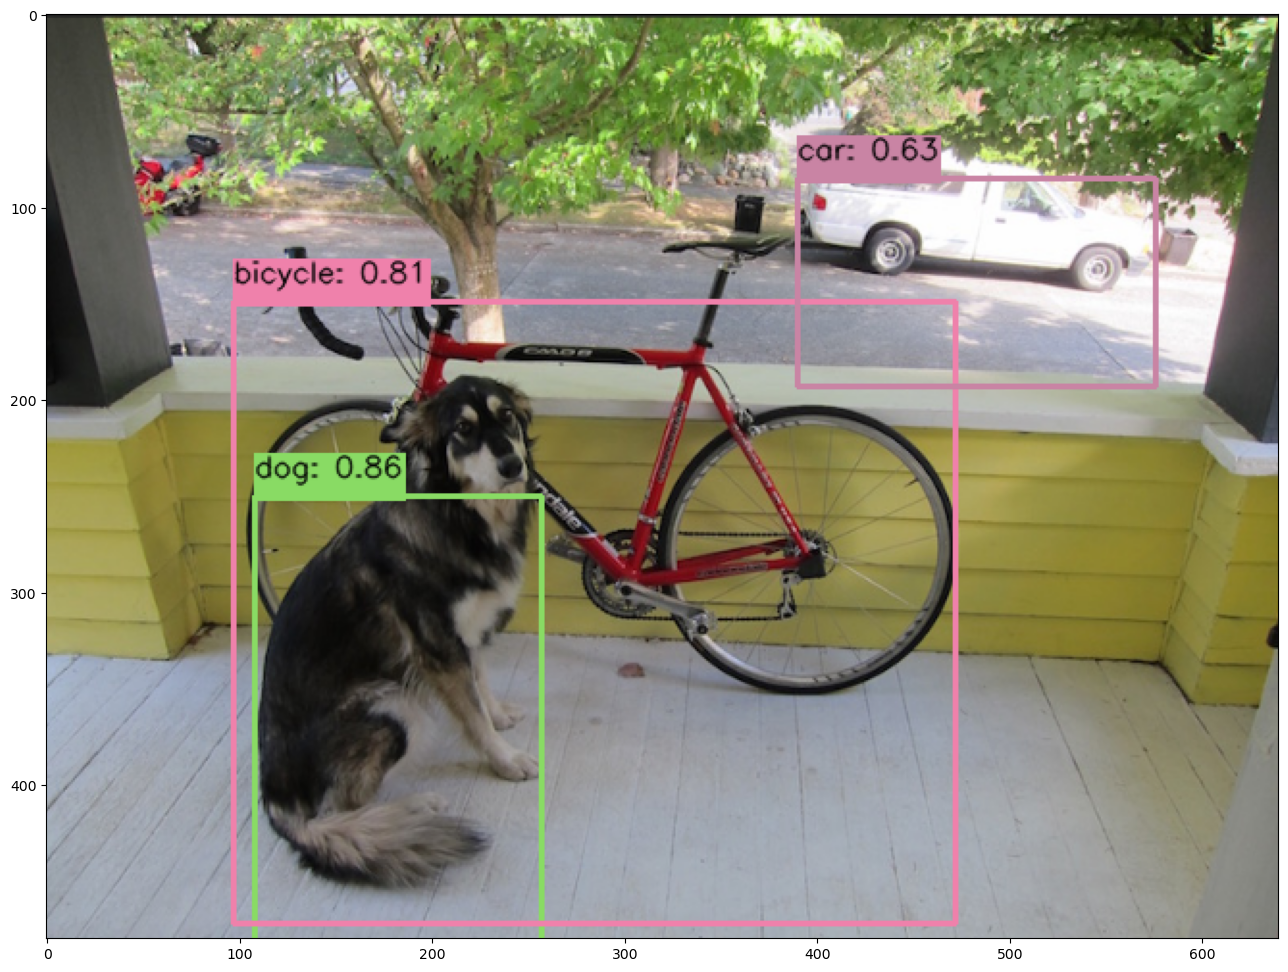

array([[[ 34,  34,  34],
        [ 35,  35,  35],
        [ 33,  33,  33],
        ...,
        [ 33,  33,  33],
        [ 33,  33,  33],
        [ 35,  35,  35]],

       [[ 41,  41,  39],
        [ 42,  42,  40],
        [ 42,  42,  40],
        ...,
        [ 81,  91,  64],
        [ 80,  92,  63],
        [ 83,  90,  59]],

       [[ 59,  61,  53],
        [ 61,  62,  54],
        [ 61,  62,  54],
        ...,
        [193, 228, 136],
        [195, 236, 136],
        [203, 224, 122]],

       ...,

       [[159, 167, 178],
        [160, 166, 178],
        [160, 165, 177],
        ...,
        [126, 127, 121],
        [126, 125, 120],
        [127, 121, 117]],

       [[160, 168, 179],
        [157, 163, 175],
        [154, 159, 171],
        ...,
        [126, 127, 121],
        [128, 126, 121],
        [127, 119, 116]],

       [[156, 164, 175],
        [155, 162, 174],
        [152, 158, 170],
        ...,
        [127, 127, 121],
        [130, 126, 122],
        [128, 119, 116]]

In [12]:
confidence_thres = 0.50
iou_thres = 0.25

cvDemo.drawYolo8Boxes(inf1, resizedImage1, width, height, confidence_thres, iou_thres, draw=True)

### Inference Through Pipeline API

Another method of performing an inference using the pipeline's deployment url.

Performing an inference through an API requires the following:

* The authentication token to authorize the connection to the pipeline.
* The pipeline's inference URL.
* Inference data to sent to the pipeline - in JSON, DataFrame records format, or Apache Arrow.

Full details are available through the [Wallaroo API Connection Guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-api-guide/wallaroo-mlops-connection-guide/) on how retrieve an authorization token and perform inferences through the pipeline's API.

For this demonstration we'll submit the pandas record, request a pandas record as the return, and set the authorization header.  The results will be stored in the file `curl_response.df`.

In [13]:
deploy_url = pipeline._deployment._url()

headers = wl.auth.auth_header()

headers['Content-Type']='application/json; format=pandas-records'
headers['Accept']='application/json; format=pandas-records'

In [14]:
!curl -X POST {deploy_url} \
    -H "Authorization:{headers['Authorization']}" \
    -H "Content-Type:application/json; format=pandas-records" \
    -H "Accept:application/json; format=pandas-records" \
    --data @./data/dogbike.df.json > curl_response.df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.0M  100 22.9M  100 15.0M  5183k  3411k  0:00:04  0:00:04 --:--:-- 8602k


In [15]:
pipeline.undeploy()

name,yolo8demonstration
created,2023-10-11 15:06:07.064939+00:00
last_updated,2023-10-11 15:06:07.988291+00:00
deployed,False
tags,
versions,"e8e7f7bb-6502-487a-8afe-2bdc2b7566b1, 01e0ac28-5040-4ee5-90cf-069abb46d06b"
steps,yolov8n
published,False


### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)` which has the following parameters and returns.

#### Publish a Pipeline Parameters

The `publish` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration]({{<ref "wallaroo-sdk-essentials-pipeline-deployment-config">}}).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### Publish Example

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

In [17]:
pub = pipeline.publish(deployment_config)
pub

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing...Published.


ID,12
Pipeline Version,995df27c-33bb-48eb-9a6c-4eed1ca90a2d
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.3.0-3854
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:995df27c-33bb-48eb-9a6c-4eed1ca90a2d
Helm Chart URL,ghcr.io/wallaroolabs/doc-samples/charts/yolo8demonstration
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:700c7e5f71fa5166b68d17d66377263becf6ae1eb8dc4d15dbf7c0335497e06f
Helm Chart Version,0.0.1-995df27c-33bb-48eb-9a6c-4eed1ca90a2d
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}, 'engineAux': {'images': {}}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 1.0, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


### List Published Pipeline

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

In [18]:
wl.list_pipelines()

name,created,last_updated,deployed,tags,versions,steps,published
yolo8demonstration,2023-11-Oct 15:06:07,2023-11-Oct 15:08:56,False,,"995df27c-33bb-48eb-9a6c-4eed1ca90a2d, af4af589-1805-4404-91f8-194308c166a0, e8e7f7bb-6502-487a-8afe-2bdc2b7566b1, 01e0ac28-5040-4ee5-90cf-069abb46d06b",yolov8n,True
yolo8demonstration,2023-11-Oct 14:37:32,2023-11-Oct 15:03:11,False,,"b3bb9d2b-a41c-4ad4-9627-6e550ec70eea, 31eb1f8f-8c8e-4f4c-acf8-8930e95f81b0, 90d31341-fcae-4c6f-b03e-b506bf979c67, 2a3933c4-52db-40c6-b80f-9031664fd08a, 95bbabf1-1f15-4e4b-9e67-f7730c2b2cbd, 6c672144-ed4f-4505-97eb-a5b1763af847, 7149e0bc-089b-4d57-9a0b-5d4f4a9a4097, 329e394b-5105-4dc3-b0ff-5411623fc139, 7acaea4e-6ae3-426b-9f97-5e3dcc39c48e, a8b2c009-e7b5-4b96-81b9-40447797a05f, 09952a45-2401-4ebd-8e85-c678365b64a7, d870a558-10ef-448e-b00d-068c10c7e82b, fa531e16-1706-43c4-98d9-e0dd6355fe6f, 4c0b535e-b39b-40f4-82a7-34965b2f7c2a, 3507964d-382f-4e1c-84c7-64c5e27f819c, 9971f8dd-a17b-4d6a-ab72-d786d4990fab, b92a035f-903c-4039-8303-8ceb979a53c2",yolov8n,True
edge-cv-demo,2023-10-Oct 16:52:02,2023-10-Oct 16:53:08,False,,"4f116503-6506-47d6-b427-1e7056a8c62e, a91a8b17-f587-439f-9001-292892e94336, 5320bc9c-e64f-4bc1-ac97-7d2b40eeb53e",resnet-50,True
edge04yolo8n,2023-10-Oct 14:48:43,2023-10-Oct 16:35:13,False,,"9b40cc1b-af1c-4521-9354-4e33e4f9d9c5, b742ddbf-2c69-4c70-b59e-bb33a6f7979c, bab6e409-af82-4678-8ba7-0f0e49997529, 4812d72c-a0ca-4432-aa6d-8a12d9a7fd02",yolov8n,False
edge-pipeline-classification-cybersecurity,2023-10-Oct 14:36:15,2023-10-Oct 14:37:08,False,,"fe99cad9-dc32-4846-bcbc-27de68975784, b53618b7-191e-44cb-b38d-bbfd9ffc7748, e1a9f56c-17f5-45f8-86bf-69ebf6c446aa",aloha,True
hf-summarizer,2023-05-Oct 16:31:44,2023-05-Oct 20:24:57,False,,"6c591132-5ba7-413d-87a6-f4221ef972a6, 60bb46b0-52b8-464a-a379-299db4ea26c0, c4c1213a-6b6e-4a98-b397-c7903e8faae4, 25ef3557-d73b-4e8b-874e-1e126693eff8, cc4bd9e0-b661-48c9-a0a9-29dafddeedcb, d359aafc-843d-4e32-9439-e365b8095d65, 8bd92035-2894-4fe4-8112-f5f3512dc8ea",hf-summarizer,True
houseprice-estimator,2023-03-Oct 18:07:05,2023-03-Oct 18:10:31,False,,"eac1e82a-e5c0-4f4b-a7fc-6583719f4a62, be1fc3f0-a769-4ce9-94e1-ba01898d91eb, 9007b5ba-d8a8-4cbe-aef7-2e9b24ee010a, d683431f-4074-4ba1-9d27-71361bd4ffd2, aaa216e0-94af-4173-b52a-b9d7c8118f17",house-price-prime,True
cv-mitochondria,2023-28-Sep 20:25:17,2023-29-Sep 19:26:53,False,,"63f71352-93bc-4e4a-85f6-0a0bf603124c, d271be10-fadd-4408-97aa-c57e6ae4e35a, ac4bd826-f47f-48b7-8319-01fbc6622899, 4b6dab7d-b3ff-4f14-8425-7d9b6de76637, 66e72bc0-a3e3-4872-bc20-19b992c194b4, cf4bdfb4-1eec-46f8-9af4-b16dea894de6, 507cb1eb-8034-4b5b-bc96-2427730a6407, 50ed1d2f-6dba-411c-9579-1090791b33bd, 6208c9cf-fcd6-4b20-bbfc-f6ce714596e3",mitochondria-detector,True
retailimage,2023-28-Sep 19:44:33,2023-28-Sep 19:54:59,False,,"26afe601-6515-48ca-9a37-d063ab1e1ea2, 1d806c89-ecc6-4207-b98f-c56eccd16c43, 11835eda-4e10-49c0-baab-63862c16d1ef, 57bf2bfb-009b-42b9-b926-742f8bbb8d3c, 891fe58d-902b-49bd-94d3-c2196a8efd3b, db0d489b-d8fa-41d3-b46f-a9623b28e336, f039eaf3-d0dd-4ab7-a767-852db5241ff0, 2f5cd92d-ecc8-4e75-aee5-1605c1f23f0e",v5s6,False
retailimage,2023-28-Sep 18:55:14,2023-28-Sep 19:23:05,False,,"d64dabed-7f7a-4f41-a307-e7995d7b8144, 8d257d18-2ca1-46b9-a40e-1f3d7f308dc1, e84586a7-05bb-4d67-a696-f04e80df8b58, 95c2157a-2722-4a5b-b564-d3a709c6238f, fa351ab0-fe77-4fc0-b521-ba15e92a91d7",v5s6,False


### List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

#### List Publishes Parameters

N/A

#### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

In [22]:
pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
11,af4af589-1805-4404-91f8-194308c166a0,None,None,john.hummel@wallaroo.ai,2023-11-Oct 15:07:13,2023-11-Oct 15:07:13
12,995df27c-33bb-48eb-9a6c-4eed1ca90a2d,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.3.0-3854,ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:995df27c-33bb-48eb-9a6c-4eed1ca90a2d,john.hummel@wallaroo.ai,2023-11-Oct 15:08:58,2023-11-Oct 15:08:58


## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.

### Docker Deployment

First, the DevOps engineer must authenticate to the same OCI Registry service used for the Wallaroo Edge Deployment registry.

For more details, check with the documentation on your artifact service.  The following are provided for the three major cloud services:

* [Set up authentication for Docker](https://cloud.google.com/artifact-registry/docs/docker/authentication)
* [Authenticate with an Azure container registry](https://learn.microsoft.com/en-us/azure/container-registry/container-registry-authentication?tabs=azure-cli)
* [Authenticating Amazon ECR Repositories for Docker CLI with Credential Helper](https://aws.amazon.com/blogs/compute/authenticating-amazon-ecr-repositories-for-docker-cli-with-credential-helper/)

For the deployment, the engine URL is specified with the following environmental variables:

* `DEBUG` (true|false): Whether to include debug output.
* `OCI_REGISTRY`: The URL of the registry service.
* `CONFIG_CPUS`: The number of CPUs to use.
* `OCI_USERNAME`: The edge registry username.
* `OCI_PASSWORD`:  The edge registry password or token.
* `PIPELINE_URL`: The published pipeline URL.

#### Docker Deployment Example

Using our sample environment, here's sample deployment using Docker with a computer vision ML model, the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```bash
docker run -p 8080:8080 \
    -e DEBUG=true -e OCI_REGISTRY={your registry server} \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=oauth2accesstoken \
    -e OCI_PASSWORD={registry token here} \
    -e PIPELINE_URL={your registry server}/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555 \
    {your registry server}/engine:v2023.3.0-main-3707
```

### Docker Compose Deployment

For users who prefer to use `docker compose`, the following sample `compose.yaml` file is used to launch the Wallaroo Edge pipeline.  This is the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```yml
services:
  engine:
    image: {Your Engine URL}
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: {Your Pipeline URL}
      OCI_REGISTRY: {Your Edge Registry URL}
      OCI_USERNAME:  {Your Registry Username}
      OCI_PASSWORD: {Your Token or Password}
      CONFIG_CPUS: 4
```

For example:

```yml
services:
  engine:
    image: sample-registry.com/engine:v2023.3.0-main-3707
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
      OCI_REGISTRY: sample-registry.com
      OCI_USERNAME:  _json_key_base64
      OCI_PASSWORD: abc123
      CONFIG_CPUS: 4
```

#### Docker Compose Deployment Example

The deployment and undeployment is then just a simple `docker compose up` and `docker compose down`.  The following shows an example of deploying the Wallaroo edge pipeline using `docker compose`.

```bash
docker compose up
[+] Running 1/1
 ✔ Container cv_data-engine-1  Recreated                                                                                                                                                                 0.5s
Attaching to cv_data-engine-1
cv_data-engine-1  | Wallaroo Engine - Standalone mode
cv_data-engine-1  | Login Succeeded
cv_data-engine-1  | Fetching manifest and config for pipeline: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
cv_data-engine-1  | Fetching model layers
cv_data-engine-1  | digest: sha256:c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   filename: c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   name: resnet-50
cv_data-engine-1  |   type: model
cv_data-engine-1  |   runtime: onnx
cv_data-engine-1  |   version: 693e19b5-0dc7-4afb-9922-e3f7feefe66d
cv_data-engine-1  |
cv_data-engine-1  | Fetched
cv_data-engine-1  | Starting engine
cv_data-engine-1  | Looking for preexisting `yaml` files in //modelconfigs
cv_data-engine-1  | Looking for preexisting `yaml` files in //pipelines
```

### Helm Deployment

Published pipelines can be deployed through the use of helm charts.

Helm deployments take up to two steps - the first step is in retrieving the required `values.yaml` and making updates to override.

1. Pull the helm charts from the published pipeline.  The two fields are the Helm Chart URL and the Helm Chart version to specify the OCI .    This typically takes the format of:

  ```bash
  helm pull oci://{published.helm_chart_url} --version {published.helm_chart_version}
  ```

1. Extract the `tgz` file and copy the `values.yaml` and copy the values used to edit engine allocations, etc.  The following are **required** for the deployment to run:

  ```yml
  ociRegistry:
    registry: {your registry service}
    username:  {registry username here}
    password: {registry token here}
  ```

  Store this into another file, suc as `local-values.yaml`.

1. Create the namespace to deploy the pipeline to.  For example, the namespace `wallaroo-edge-pipeline` would be:

  ```bash
  kubectl create -n wallaroo-edge-pipeline
  ```

1. Deploy the `helm` installation with `helm install` through one of the following options:
    1. Specify the `tgz` file that was downloaded and the local values file.  For example:

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {tgz path}
        ```

    1. Specify the expended directory from the downloaded `tgz` file.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {helm directory path}
        ```

    1. Specify the Helm Pipeline Helm Chart and the Pipeline Helm Version.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} oci://{published.helm_chart_url} --version {published.helm_chart_version}
        ```

1. Once deployed, the DevOps engineer will have to forward the appropriate ports to the `svc/engine-svc` service in the specific pipeline.  For example, using `kubectl port-forward` to the namespace `ccfraud` that would be:

    ```bash
    kubectl port-forward svc/engine-svc -n ccfraud01 8080 --address 0.0.0.0`
    ```

The following code segment generates a `docker run` template based on the previously published pipeline.  Replace the `$REGISTRYURL`, `$REGISTRYUSERNAME`, and `$REGISTRYPASSWORD` to match the OCI Registry being used.

In [23]:
docker_deploy = f'''
docker run -p 8080:8080 \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e CONFIG_CPUS=4 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={pub.pipeline_url} \\
    {pub.engine_url}
'''

print(docker_deploy)


docker run -p 8080:8080 \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=ghcr.io/wallaroolabs/doc-samples/pipelines/yolo8demonstration:995df27c-33bb-48eb-9a6c-4eed1ca90a2d \
    ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.3.0-3854



## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

```bash
curl localhost:8080/pipelines
{"pipelines":[{"id":"edge-cv-retail","status":"Running"}]}
```

The following example uses the host `localhost`.  Replace with your own host name of your Edge deployed pipeline.

In [24]:
!curl localhost:8080/pipelines

{"pipelines":[{"id":"yolo8demonstration","status":"Running"}]}

The endpoint `/models` returns a List of models with the following fields:

* **name** (*String*): The model name.
* **sha** (*String*): The sha hash value of the ML model.
* **status** (*String*):  The status of either Running or Error if there are any issues.
* **version** (*String*):  The model version.  This matches the version designation used by Wallaroo to track model versions in UUID format.

```bash
curl localhost:8080/models
{"models":[{"name":"resnet-50","sha":"c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984","status":"Running","version":"693e19b5-0dc7-4afb-9922-e3f7feefe66d"}]}
```

The following example uses the host `localhost`.  Replace with your own host name of your Edge deployed pipeline.

In [25]:
!curl localhost:8080/models

{"models":[{"name":"yolov8n","sha":"3ed5cd199e0e6e419bd3d474cf74f2e378aacbf586e40f24d1f8c89c2c476a08","status":"Running","version":"c7e7bad9-1f5f-4b1d-bea7-e1c328616242"}]}

### Edge Inference Endpoint

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.

Once deployed, we can perform an inference through the deployment URL.

The endpoint returns `Content-Type: application/json; format=pandas-records` by default with the following fields:

* **check_failures** (*List[Integer]*): Whether any validation checks were triggered.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing]({{<ref "wallaroo-sdk-essentials-pipeline#anomaly-testing">}}).
* **elapsed** (*List[Integer]*): A list of time in nanoseconds for:
  * [0] The time to serialize the input.
  * [1...n] How long each step took.
* **model_name** (*String*): The name of the model used.
* **model_version** (*String*): The version of the model in UUID format.
* **original_data**: The original input data.  Returns `null` if the input may be too long for a proper return.
* **outputs** (*List*): The outputs of the inference result separated by data type, where each data type includes:
  * **data**: The returned values.
  * **dim** (*List[Integer]*): The dimension shape returned.
  * **v** (*Integer*): The vector shape of the data.
* **pipeline_name**  (*String*): The name of the pipeline.
* **shadow_data**: Any shadow deployed data inferences in the same format as **outputs**.
* **time** (*Integer*): The time since UNIX epoch.
  
Once deployed, we can perform an inference through the deployment URL.  We'll assume we're running the inference request through the localhost and submitting the local file `./data/image_224x224.arrow`.  Note that our inference endpoint is `pipelines/edge-cv-retail` - the same as our pipeline name.

The following example demonstrates sending an inference request to the edge deployed pipeline.

In [28]:
!curl -X POST localhost:8080/pipelines/yolo8demonstration \
    -H "Content-Type: application/json; format=pandas-records" \
        --data @./data/dogbike.df.json > edge-results.df.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28.7M  100 13.6M  100 15.0M  14.2M  15.8M --:--:-- --:--:-- --:--:-- 30.6M
